In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm
from scipy import stats

In [2]:
from utils import *

In [3]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setup your PBSCluster

project = 'P93300641' #input your project code

m='10GB'
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=m, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+m, # Specify resources
    project=project, # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

In [5]:
def lens_files(model,dv,yy=(1960,2050)):
    
    y1=yy[0]
    y2=yy[1]
    
    if model=='CESM1':
        d='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/monthly/'+dv+'/'
        match=['C5CNBDRD','h0']
        nixes=['OIC','106','107']
    else:
        d='/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'+dv+'/'
        match=['f09_g17','h0']
        nixes=[]
        
    #find all files
    fs=sorted(glob.glob(d+'*'))

    #nix some
    files=[]
    for f in fs:
        add=True
        for m in match:
            if m not in f:
                add=False
        for n in nixes:
            if n in f:
                add=False
        if add:
            files.append(f)
    files=np.array(files)

    #filter to match years
    yr1s = np.array([int(f.split('.')[-2].split('-')[0][:4]) for f in files])
    yr2s = np.array([int(f.split('.')[-2].split('-')[1][:4]) for f in files])
    ix=((yr1s<=y2)&(yr1s>=y1))|((yr2s<=y2)&(yr2s>=y1))
    files=files[ix]

    #sort by member
    mems = np.array([f.split('f09')[1].split('clm2')[0] for f in files])
    out=[list(files[mems==mem]) for mem in np.unique(mems)]
    
    return out

In [6]:
def get_ds(files,dims,dvs=[],appends={},singles=[],yy=None):
    if dvs:
        def preprocess(ds):
            return ds[dvs]
    else:
        def preprocess(ds):
            return ds
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=dims,
                   parallel=True,
                   preprocess=preprocess)

    f=np.array(files).ravel()[0]
    htape=f.split('clm2')[1][1:3]

    #add extra variables
    tmp = xr.open_dataset(f)
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims: 
            if v not in ds:
                ds[v]=tmp[v]
    
    #fix up time dimension, swap pft
    if (htape=='h0')|(htape=='h1'):
        yr0=str(ds['time.year'][0].values)
        nt=len(ds.time)
        ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    if (htape=='h1'):
        ds['pft']=ds['pfts1d_itype_veg']
        
    
    for append in appends:
        ds[append]=appends[append]
        
    if yy:
        ds=ds.sel(time=slice(str(yy[0]),str(yy[1])))
             
    return ds

### annualizing CESM2

In [7]:
carbons=['NBP','GPP','AR','HR','COL_FIRE_CLOSS','NPP']
cfs={v:[24*60*60,1e-9,'PgC/yr'] for v in carbons}
waters=['SOILWATER_10CM','TWS','SW']
for w in waters:
    cfs[w]=[None,1e-9,'TtH2O']
cfs

{'NBP': [86400, 1e-09, 'PgC/yr'],
 'GPP': [86400, 1e-09, 'PgC/yr'],
 'AR': [86400, 1e-09, 'PgC/yr'],
 'HR': [86400, 1e-09, 'PgC/yr'],
 'COL_FIRE_CLOSS': [86400, 1e-09, 'PgC/yr'],
 'NPP': [86400, 1e-09, 'PgC/yr'],
 'SOILWATER_10CM': [None, 1e-09, 'TtH2O'],
 'TWS': [None, 1e-09, 'TtH2O'],
 'SW': [None, 1e-09, 'TtH2O']}

In [10]:
#read in the easy data
model='CESM2'
ds=False
yy=(1850,2100)
dvs=['NBP','TWS','SOILWATER_10CM','TBOT','FSDS','GPP','AR','HR','COL_FIRE_CLOSS']
for v in dvs:
    print(v)
    files=lens_files(model,v,yy=yy)
    if not ds:
        ds = get_ds(files,['ens','time'],dvs=[v],yy=yy)
    else:
        tmp = get_ds(files,['ens','time'],dvs=[v],yy=yy)
        ds[v]=tmp[v]
tmp=get_vpd(model,yy)
for v in ['ESAT','RH','VPD']:
    ds[v]=tmp[v]

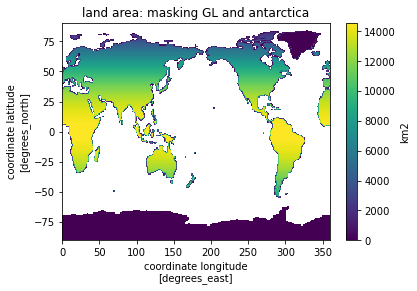

In [15]:
import regionmask
mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(ds.lon,ds.lat)
gl=(mask==22)
la=(~gl)*ds.landfrac*ds.area*(ds.lat>-60)
la.plot(cbar_kwargs={'label':'km2'})
plt.title('land area: masking GL and antarctica');
#greenland mask is not perfect.....

In [16]:
dsout=xr.Dataset()
for v in ds.data_vars:
    if 'ens' in ds[v].dims:
        print(v)
        if v not in cfs:
            cf1,cf2,u=None,None,ds[v].attrs['units']   
        else:
            cf1,cf2,u=cfs[v]
        ln=ds[v].attrs['long_name']

        dsout[v]=gmean(amean(ds[v],cf1),la,cf=cf2,ln=ln,u=u)
        

NBP
TWS
SOILWATER_10CM
TBOT
FSDS
GPP
AR
HR
COL_FIRE_CLOSS
RH2M
ESAT
RH
VPD


In [21]:
dsout.attrs={'derived from:':'CESM2 large ensemble (Rodgers et al. 2021)',
             'note:':'Greenland and Antarctica are masked out'}
dsout.to_netcdf('/glade/u/home/djk2120/TWSnbp/data/CESM2_glob_ann.nc')

In [178]:
x=detrend_dim(gmean(amean(ds.TWS.sel(time=yy)),la,cf=1e-9),'year')

In [185]:
y=detrend_dim(gmean(amean(ds.SOILWATER_10CM.sel(time=yy),24*60*60),la,cf=1e-9),'year')

In [186]:
z=detrend_dim(gmean(amean(ds.NBP.sel(time=yy),24*60*60),la,cf=1e-9),'year')

In [237]:
t=detrend_dim(gmean(amean(ds.TBOT.sel(time=yy)),la),'year')

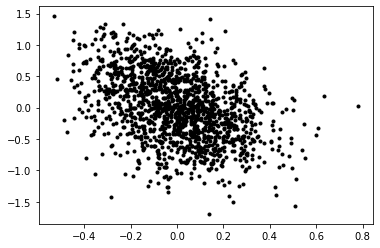

In [238]:
plt.plot(t,z,'k.');

In [230]:
yy=slice('1971','1985')
fsds=gmean(amean(ds.FSDS.sel(time=yy)),la)

(array([  5.,  39.,  85., 194., 322., 391., 295., 145.,  18.,   6.]),
 array([193.1983045 , 193.70132571, 194.20434693, 194.70736814,
        195.21038935, 195.71341057, 196.21643178, 196.71945299,
        197.22247421, 197.72549542, 198.22851664]),
 <BarContainer object of 10 artists>)

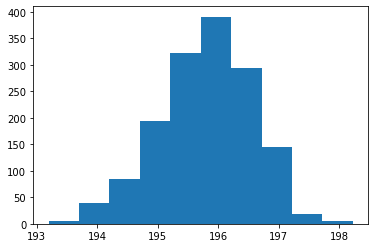

In [232]:
plt.hist(fsds.values.ravel())

In [193]:
np.corrcoef(x.values.ravel(),y.values.ravel())**2

array([[1.        , 0.41608301],
       [0.41608301, 1.        ]])

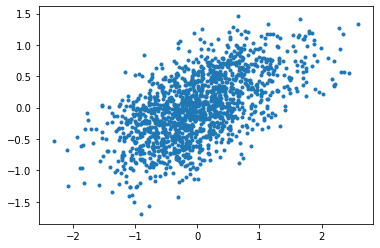

In [187]:
plt.plot(x.values.ravel(),z.values.ravel(),'.')

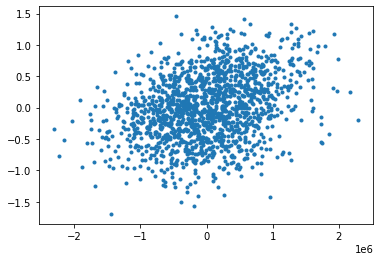

In [188]:
plt.plot(y.values.ravel(),z.values.ravel(),'.')

In [189]:
sm.OLS(z.values.ravel(),x.values.ravel()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.353
Model:                            OLS   Adj. R-squared (uncentered):              0.352
Method:                 Least Squares   F-statistic:                              816.6
Date:                Thu, 13 Apr 2023   Prob (F-statistic):                   9.66e-144
Time:                        15:01:32   Log-Likelihood:                         -845.71
No. Observations:                1500   AIC:                                      1693.
Df Residuals:                    1499   BIC:                                      1699.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4221      0.015     28.577      0.000       0.393       0.451
==============================================================================
Omnibus:                        6.464   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.371
Skew:                          -0.063   Prob(JB):                       0.0682
Kurtosis:                       2.735   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
sm.OLS(z.values.ravel(),y.values.ravel()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.102
Model:                            OLS   Adj. R-squared (uncentered):              0.102
Method:                 Least Squares   F-statistic:                              170.8
Date:                Thu, 13 Apr 2023   Prob (F-statistic):                    4.73e-37
Time:                        15:01:42   Log-Likelihood:                         -1090.9
No. Observations:                1500   AIC:                                      2184.
Df Residuals:                    1499   BIC:                                      2189.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           2.43e-07   1.86e-08     13.071      0.000    2.07e-07    2.79e-07
==============================================================================
Omnibus:                        6.502   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.130
Skew:                          -0.118   Prob(JB):                       0.0467
Kurtosis:                       2.793   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

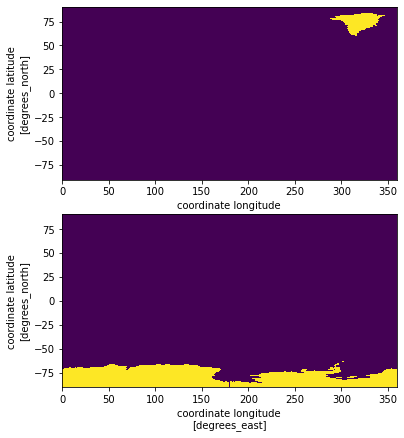

In [149]:
plt.figure(figsize=[6,7])
plt.subplot(211)
(mask==22).plot(add_colorbar=False)#greenland
plt.subplot(212)
(mask==159).plot(add_colorbar=False);#antarctica

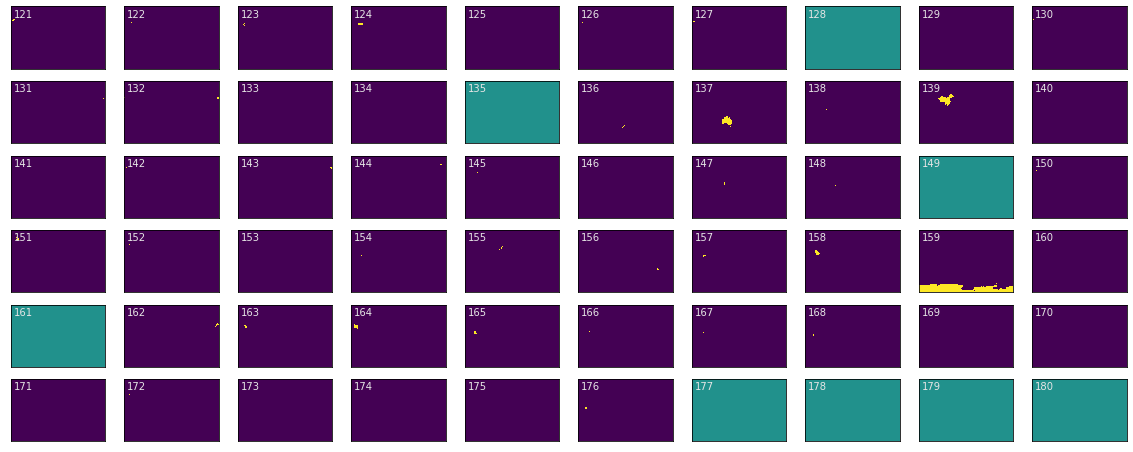

In [141]:
plt.figure(figsize=[20,8])
i0=121
for i in range(i0,i0+60):
    plt.subplot(6,10,1+i-i0)
    (mask==i).plot(add_colorbar=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.text(10,60,i,color=np.ones(3)-0.1)

In [107]:
help(get_ds)

Help on function get_ds in module __main__:

get_ds(files, dims, dvs=[], appends={}, singles=[], yy=None)



In [7]:
def get_sw(model,yy=(1960,2050)):
    
    v='H2OSOI'
    files=lens_files(model,v,yy=yy)
    tmp=xr.open_dataset(files[0][0])
    for dim in tmp.H2OSOI.dims:
        if 'lev' in dim:
            sdim=dim
    ns=len(tmp.H2OSOI[sdim])
    dz=xr.DataArray(1000*tmp.DZSOI.sel(lat=30,lon=105,method='nearest')[:ns].values,
                    dims=sdim,name='Soil thickness',attrs={'units':'m'})
    
    def preprocess(ds):
        return (dz*ds.H2OSOI).sum(dim=sdim).compute()
    
    fours = zip(*(iter(files),) * 4)
    das=[]
    for four in fours:
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            da=xr.open_mfdataset(four,combine='nested',concat_dim=['ens','time'],
                                 parallel=True,chunks={'time':24},preprocess=preprocess)
        das.append(da)
    da=xr.concat(das,dim='ens')
    ds=xr.Dataset()
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            ds[v]=tmp[v]
    yr0=str(da['time.year'][0].values)
    nt=len(da.time)
    da['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    m=ds.ZSOI.isel(levgrnd=0)>0
    ds['SW']=da.where(m)
    ds['SW'].attrs={'long_name':'Total column soil water',
                    'notes':'processed from H2OSOI',
                    'units':'mm'}
    
    
    return ds.sel(time=slice(str(yy[0]),str(yy[1])))

In [9]:
def gmean(da,la,cf=None,ln=None,u=None):
    #global mean
    if not cf:
        cf=1/la.sum()
    xg = cf*(la*da).sum(dim=['lat','lon']).compute()
    xg.name=da.name
    xg.attrs={'long_name':ln,'units':u}
    return xg

In [10]:

def brown_green():
    '''
    returns a colormap based on colorbrewer diverging brown->green
    '''

    # colorbrewer colormap, diverging, brown->green
    cmap = np.zeros([11,3]);
    cmap[0,:] = 84,48,5
    cmap[1,:] = 140,81,10
    cmap[2,:] = 191,129,45
    cmap[3,:] = 223,194,125
    cmap[4,:] = 246,232,195
    cmap[5,:] = 245,245,245
    cmap[6,:] = 199,234,229
    cmap[7,:] = 128,205,193
    cmap[8,:] = 53,151,143
    cmap[9,:] = 1,102,94
    cmap[10,:] = 0,60,48
    cmap = matplotlib.colors.ListedColormap(cmap/256)
    
    return cmap

In [11]:
from scipy import stats

In [12]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### annualize PPE data

In [52]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("/glade/u/home/djk2120/ppe_tools/")
from ppe_analysis.analysis import *

In [93]:
dvs=['NBP','TWS']
ds=get_exp('transient',dvs,yy=(1991,2005))

In [94]:
dsout=xr.Dataset()
for v in dvs:
    cf1,cf2,u=cfs[v]
    x=gmean(amean(ds[v],cf=cf1),ds.la,cf=cf2,u=u)
    dsout[v]=x


In [100]:
dsout['params']=ds.params
for p in ds.params.values:
    dsout[p]=ds[p]
dsout.to_netcdf('data/PPE_glob_ann.nc')

In [24]:
def get_exp(model,dvs,yy=(1960,2050)):
    dsets=[]
    for dv in dvs:
        if dv=='SW':
            ds=get_sw(model,yy=yy)
        else:
            files=lens_files(model,dv,yy=yy)
            ds=get_ds(files,['ens','time'],dvs=[dv],yy=yy)
        dsets.append(ds)
    i=0
    for ds,dv in zip(dsets,dvs):
        if i==0:
            dsout=ds
            i+=1
        else:
            dsout[dv]=ds[dv]
    return dsout

In [14]:
#calculate and save annual means

In [51]:
model='CESM2'
d='/glade/u/home/djk2120/TWSnbp/data/'
f=model+'_glob_mean.nc'
dsout=xr.open_dataset(d+f)
ds=get_exp(model,['NPP'])
la=ds.landfrac*ds.area
v='NPP'
cf1,cf2,u=cfs[v]
x=gmean(amean(ds[v],cf1),la,cf=cf2,u=u,ln=ds[v].attrs['long_name'])
dsout[v]=x
write_nc(dsout,d,f)

In [47]:
def write_nc(dsadd,d,f):

    files=sorted(glob.glob(d+f+'*.nc'))
    
    if len(files)==0:
        dsadd.to_netcdf(d+f+'.nc')
    else:
        file=files[-1]
        if 'zqz' in file:
            i0=int(file.split('zqz')[1].split('.')[0])
        else:
            i0=0

        ds0=xr.open_dataset(file)
        file2=d+f+'zqz'+str(i0+1).zfill(2)+'.nc'
        for v in dsadd.data_vars:
            if v not in ds0:
                ds0[v]=dsadd[v]
                
        ds0.to_netcdf(file2)

In [50]:
def cleanup(d):
    files=glob.glob(d+'*.nc')
    fdict={}
    for file in files:
        if 'zqz' in file:
            f2=file.split('zqz')[0]+'.nc'
            i=int(file.split('zqz')[1].split('.')[0])
            if f2 not in fdict:
                fdict[f2]={i:file}
            else:
                fdict[f2][i]=file
    for f in fdict:
        ivals=[i for i in fdict[f]]
        imax=max(ivals)
        for i in fdict[f]:
            if i==imax:
                cmd='mv '+fdict[f][i]+' '+f
            else:
                cmd='rm '+fdict[f][i]
            print(cmd)
            os.system(cmd)

In [196]:
output={}
models=['CESM1','CESM2']
for model in models:
    print(model)
    ds=get_exp(model,['SW','NBP'],yy=(1991,2005))
    nbpann=detrend_dim(amean(ds.NBP,cf=24*60*60),'year').stack(ensyear=['ens','year']).compute()
    swann=detrend_dim(amean(ds.SW),'year').stack(ensyear=['ens','year']).compute()
    m,r,p=mvals(swann,nbpann,ds.landfrac)
    output[model]=(m,r,p)

CESM1
CESM2


In [248]:
dsm=xr.Dataset()
s=[*ds.area.shape,1]
names=['slope','correlation','pvalue']
for i in range(3):
    da=xr.DataArray(np.concatenate([output[m][i].reshape(s) for m in output],axis=2),dims=['lat','lon','model'])
    dsm[names[i]]=da
    
dsm['lat']=ds.lat
dsm['lon']=ds.lon
dsm['model']=models
dsm.slope.attrs={'long_name':'NBP sensitivity to SW','units':r'gC/kgH$_2$O'}
dsm.correlation.attrs={'long_name':r"Pearson correlation coefficient ($\rho$)"}
dsm.attrs={'years':'1991-2005','data':'pooling all ensemble members'}
dsm.to_netcdf('data/slope_maps.nc')

In [247]:
dsm

<xarray.Dataset>
Dimensions:      (lon: 288, lat: 192, model: 2)
Coordinates:
  * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * model        (model) <U5 'CESM1' 'CESM2'
Data variables:
    slope        (lat, lon, model) float64 nan nan nan nan ... nan nan nan nan
    correlation  (lat, lon, model) float64 nan nan nan nan ... nan nan nan nan
    pvalue       (lat, lon, model) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    years:    1991-2005
    data:     pooling all ensemble members

In [243]:
dsm.correlation

<xarray.DataArray 'correlation' (lat: 192, lon: 288, model: 2)>
array([[[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
...
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * model    (model) <U5 'CESM1' 'CESM2'
Attributes:
    long_name:  Pearson correlation coefficient ($\rho$)

In [216]:
m=xr.DataArray(output['CESM2'][0],dims=['lat','lon'],name='c')
m['lat']=ds.lat
m['lon']=ds.lon

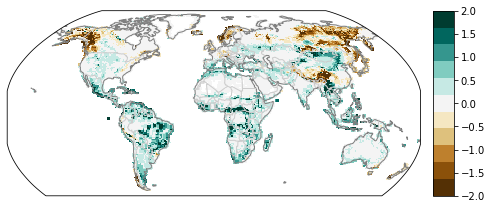

In [217]:
nicemap(m,'','',vmax=2)

In [190]:
def mvals(xann,yann,lf,dim='ensyear'):
    ix=((lf>0)&(xann.std(dim=dim)>0)&(yann.std(dim=dim)>0)).compute()
    ivals=np.tile(np.arange(192).reshape([-1,1]),[1,288])
    jvals=np.tile(np.arange(288),[192,1])
    
    mvals=np.zeros(ix.shape)+np.nan
    rvals=np.zeros(ix.shape)+np.nan
    pvals=np.zeros(ix.shape)+np.nan
    for i,j in zip(ivals[ix],jvals[ix]):
        x=swann.isel(lat=i,lon=j)
        y=nbpann.isel(lat=i,lon=j)
        mvals[i,j],b,rvals[i,j],pvals[i,j],stderr=stats.linregress(x,y)

    return mvals,rvals,pvals

In [213]:
pvals=output['CESM2'][2]


In [181]:
dsm=xr.Dataset()

In [184]:
mvals.reshape[

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
names=['slope','correlation',

In [107]:

m['lat']=ds.lat
m['lon']=ds.lon

In [136]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    label = kwargs.pop('label',None)
    cticks = kwargs.pop('cticks',[])
    cticklabs = kwargs.pop('cticklabs',[])
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
        
    cax = divider.append_axes(loc, '5%', pad='3%', axes_class=mpl.pyplot.Axes)

    cbar=ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation,label=label)
    if len(cticks)>0:
        cbar.set_ticks(cticks)
    if len(cticklabs)>0:
        cbar.set_ticklabels(cticklabs)

In [141]:
def nicemap(da,tstr,cbl,cmap=brown_green(),vmax=None,
            vminmax=None,cticks=[],cticklabs=[],fsz=(8, 4)):
    fig = plt.Figure(figsize=fsz)
    ax = fig.add_subplot(111,projection=ccrs.Robinson())
    ax.set_extent([-180, 180,-60,90], crs=ccrs.PlateCarree())
    
    dmap=da

    if vminmax:
        mappable = dmap.plot(transform=ccrs.PlateCarree(),cmap=cmap,
                             add_colorbar=False,ax=ax,
                             vmax=vminmax[1],vmin=vminmax[0])
    elif vmax:
        mappable = dmap.plot(transform=ccrs.PlateCarree(),cmap=cmap,
                             add_colorbar=False,ax=ax,vmax=vmax,vmin=-vmax)
    else:
        mappable = dmap.plot(transform=ccrs.PlateCarree(),cmap=cmap,
                             add_colorbar=False,ax=ax)
        
    ax.set_title(tstr)
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    ax.coastlines(color='grey')
    ax.add_feature(cfeature.BORDERS,edgecolor=[0.8,0.8,0.8])

    make_colorbar(ax,mappable,label=cbl,cticks=cticks,cticklabs=cticklabs)
    
    return fig

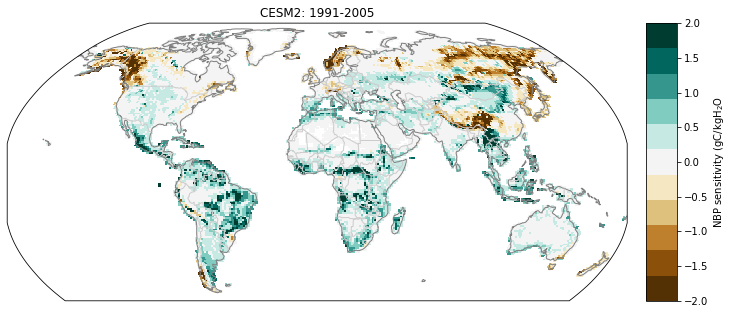

In [152]:
wts=(ds.landfrac*ds.area*swann.var(dim='ensyear')).values
wts=wts/np.nansum(wts)

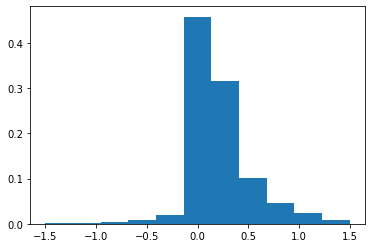

In [155]:
plt.hist(da.values.ravel(),np.linspace(-1.5,1.5,12),weights=wts.ravel());

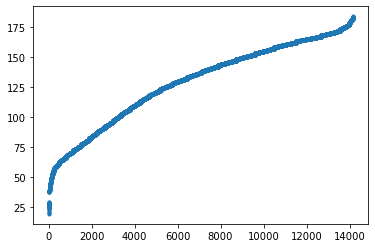

In [67]:
plt.plot(ivals[ix],'.')

In [50]:
p

4.865256581016089e-47

In [44]:
np.corrcoef(sw,nbp)

array([[1.        , 0.35969726],
       [0.35969726, 1.        ]])

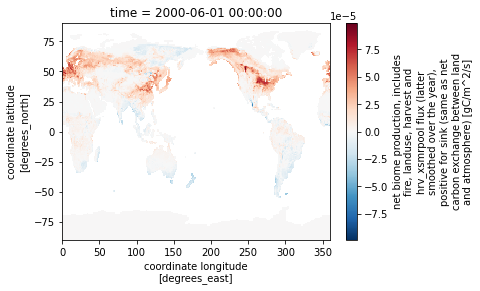

In [40]:
ds.NBP.sel(ens=0,time='2000-06').plot()

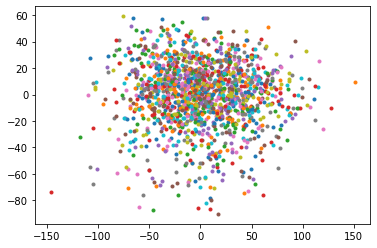

In [33]:
plt.plot(sw,nbp,'.');

In [104]:
yy=slice('1991','2005')

In [107]:
ix=(ds.landfrac>0).stack(gridcell=['lat','lon'])

In [114]:
nbp0=amean(ds.NBP.sel(time=yy).stack(gridcell=['lat','lon']).isel(gridcell=ix),cf=24*60*60).stack(ensyear=['ens','year'])
sw0=amean(ds.SW.sel(time=yy).stack(gridcell=['lat','lon']).isel(gridcell=ix)).stack(ensyear=['ens','year'])

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [118]:
ix=(nbp0.std(dim='ensyear')>0)&(sw0.std(dim='ensyear')>0)

In [149]:
m=np.zeros(len(nbp0.gridcell))+np.nan
for i,g in enumerate(nbp0.gridcell[ix]):
    sw=sw0.sel(gridcell=g)
    nbp=nbp0.sel(gridcell=g)
    m[i], b, r, p, std_err = stats.linregress(sw,nbp)
    

In [150]:
wts=(ds.area*ds.landfrac).stack(gridcell=['lat','lon'])*sw0.var(dim='ensyear')

In [151]:
mvals=xr.DataArray(m,dims=['gridcell'])

In [153]:
mvals['gridcell']=nbp0.gridcell

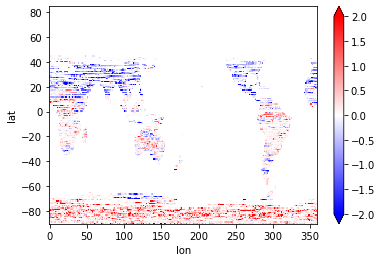

In [158]:
mvals.unstack().plot(vmin=-2,vmax=2,cmap='bwr')

In [102]:

nbp0=detrend_dim(amean(ds.NBP.sel(time=yy),cf=24*60*60),'year').stack(gridcell=['lat','lon'],ensyear=['ens','year'])
sw0 =detrend_dim(amean(ds.SW.sel(time=yy)),'year').stack(gridcell=['lat','lon'],ensyear=['ens','year'])

KeyboardInterrupt: 

<xarray.DataArray (gridcell: 55296)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * gridcell  (gridcell) MultiIndex
  - lat       (gridcell) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  - lon       (gridcell) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8

In [59]:
ix=(ds.landfrac.stack(gridcell=['lat','lon'])>0)


In [65]:
nbp=detrend_dim(amean(ds.NBP.sel(time=yy),cf=24*60*60),'year').stack(gridcell=['lat','lon']).isel(gridcell=ix)

17875


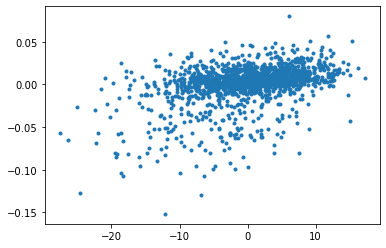

In [94]:
i=np.random.randint(20000)
print(i)
x=sw.isel(gridcell=i).values.ravel()
y=nbp.isel(gridcell=i).values.ravel()
if x.std()>0:
    if y.std()>0:
        stats.linregress(x,y)
plt.plot(x,y,'.')

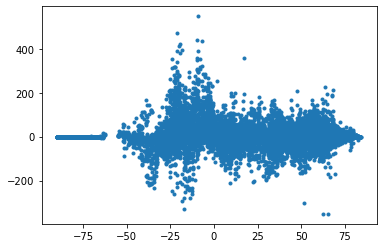

In [64]:
plt.plot(sw.gridcell.lat,sw.sel(ens=0,year=2005),'.')

In [39]:

ivals=np.tile(np.arange(192).reshape([-1,1]),[1,288])[ix]
jvals=np.tile(np.arange(288),[192,1])[ix]

In [54]:
lats=np.tile(ds.lat.values.reshape([-1,1]),[1,288])
lons=np.tile(ds.lat.values.reshape([-1,1]),[1,288])

In [57]:
lats.ravel()

array([-90., -90., -90., ...,  90.,  90.,  90.], dtype=float32)

In [52]:
sw.gridcell

<xarray.DataArray 'gridcell' (gridcell: 55296)>
array([(-90.0, 0.0), (-90.0, 1.25), (-90.0, 2.5), ..., (90.0, 356.25),
       (90.0, 357.5), (90.0, 358.75)], dtype=object)
Coordinates:
  * gridcell  (gridcell) MultiIndex
  - lat       (gridcell) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  - lon       (gridcell) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8

In [44]:
y=nbp.sel(lat=30,lon=105,method='nearest')
x=sw.sel(lat=30,lon=105,method='nearest')

<xarray.DataArray (year: 15, ens: 100)>
array([[ 23.39695959,   3.05435828,  14.05872214, ...,  -9.69534895,
         65.6323506 , -47.90644201],
       [-21.58316549, -40.95233358,   7.95715644, ...,  33.42702788,
         -4.45767467,  -5.48641343],
       [-28.47058302, -41.0840609 ,  48.24350044, ...,   0.50359658,
        -63.75600006, -17.97646218],
       ...,
       [ 19.06974534,  31.57839559,  77.7143726 , ...,  36.7924839 ,
         49.04494552, -30.46759303],
       [ -5.11714779,  11.48776985,   2.1704368 , ..., -52.62862205,
         -1.31796208,   4.05843539],
       [ 29.30617152, -37.6979801 ,  46.2538404 , ...,  28.32784083,
        -11.65239486, -49.7354768 ]])
Coordinates:
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
    lon      float32 105.0
    lat      float32 29.69
  * year     (year) int64 1991 1992 1993 1994 1995 ... 2001 2002 2003 2004 2005